# Proyecto ICI-426
## Análisis de Redes Sociales

**Profesora:** Ana Aguilera

**Integrantes:**

- Martin Hernandez
- Angel Salgado


In [50]:
import pandas as pd
import numpy as np
import networkx as nx
import operator
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

import warnings
warnings.filterwarnings('ignore')

import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
import ndlib.viz.mpl as viz

%matplotlib inline

In [2]:
# Inicialización de grafos
graph = nx.Graph()

### Dataset escogido

Para el desarrollo del proyecto se escogió el dataset *Wikipedia vote network*. En este [dataset](https://snap.stanford.edu/data/wiki-Vote.html) se recopila información de las votaciones para elecciones de administradores de Wikipedia hasta enero de 2008. Incluye 2,794 elecciones, con 103,663 votos emitidos por 7,066 usuarios. 

En esta red, los nodos representan usuarios, y los bordes dirigidos indican que un usuario votó por otro.

In [3]:
file_path = "Wiki-Vote.txt"
data = []
with open(file_path, 'r') as f:
    for line in f:
        if not line.startswith('#'):
            data.append(line.strip().split('\t'))

# Convertir los datos a un DataFrame
df = pd.DataFrame(data, columns=['FromNodeId', 'ToNodeId'])

# Convertir las columnas a tipo numérico
df['FromNodeId'] = pd.to_numeric(df['FromNodeId'], errors='coerce')
df['ToNodeId'] = pd.to_numeric(df['ToNodeId'], errors='coerce')

# Eliminar filas con valores nulos o duplicados
df = df.dropna().drop_duplicates()

# Guardar el dataset depurado
df.to_csv("Wiki-Vote_cleaned.csv", index=False)
print("Dataset depurado y guardado como Wiki-Vote_cleaned.csv")

Dataset depurado y guardado como Wiki-Vote_cleaned.csv


In [4]:
clean_df = pd.read_csv("Wiki-Vote_cleaned.csv")

In [5]:
clean_df

,FromNodeId,ToNodeId
0,30,1412
1,30,3352
2,30,5254
3,30,5543
4,30,7478
...,...,...
103684,8272,4940
103685,8273,4940
103686,8150,8275
103687,8150,8276


Despues de la depuración, y guardado en un archivo csv, se tienen 103.689 relaciones a estudiar en el proyecto.

Posteriormente, es necesario calcular las medidas de centralidad.

# Medidas de Centralidad

In [6]:
# Crear el grafo dirigido
G = nx.DiGraph()

# Agregar aristas desde el DataFrame
edges = list(zip(clean_df['FromNodeId'], clean_df['ToNodeId']))
G.add_edges_from(edges)

In [7]:
# Calcular centralidades
in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())
closeness = nx.closeness_centrality(G)
betweenness = nx.betweenness_centrality(G)
pagerank = nx.pagerank(G)

# Crear DataFrame con las métricas
centralities = pd.DataFrame({
    'Node': list(G.nodes()),
    'In-Degree': [in_degree.get(node, 0) for node in G.nodes()],
    'Out-Degree': [out_degree.get(node, 0) for node in G.nodes()],
    'Closeness': [closeness.get(node, 0) for node in G.nodes()],
    'Betweenness': [betweenness.get(node, 0) for node in G.nodes()],
    'PageRank': [pagerank.get(node, 0) for node in G.nodes()]
})

# Guardar el resultado
centralities.to_csv("Centralities_WikiVote.csv", index=False)
print("Medidas de centralidad guardadas en Centralities_WikiVote.csv")

Medidas de centralidad guardadas en Centralities_WikiVote.csv


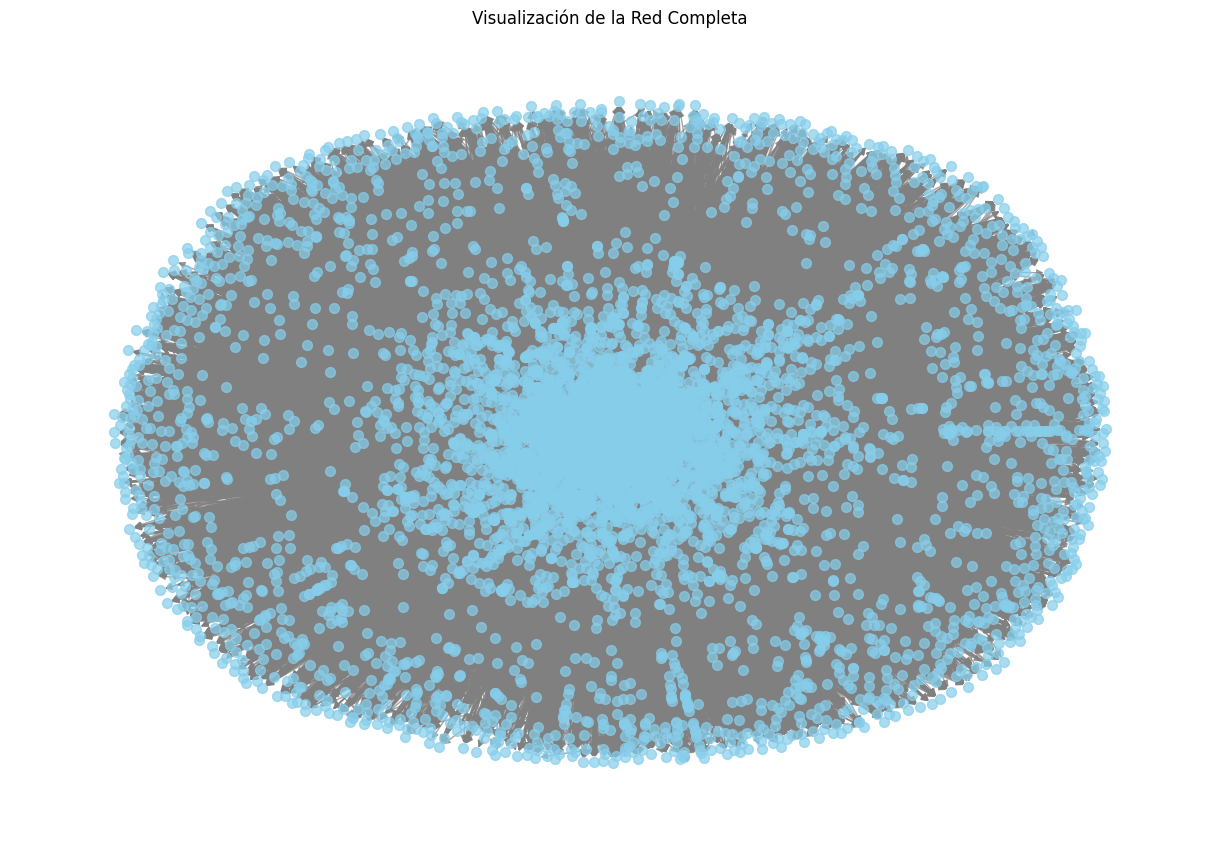

In [15]:
# Dibujar la red completa
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # Diseño de la red
nx.draw(
    G,
    pos,
    with_labels=False,
    node_size=50,
    node_color="skyblue",
    edge_color="gray",
    alpha=0.7
)
plt.title("Visualización de la Red Completa")
plt.show()

### Aplicacion de Linear Threshold Model

In [11]:
# Inicialización del modelo
lt_model = ep.ThresholdModel(G)

# Configuracion del modelo
config = mc.Configuration()
config.add_model_parameter('fraction_infected', 0.1)
for node in G.nodes():
    config.add_node_configuration("threshold", node, 0.2)
lt_model.set_initial_status(config)
iterations_lt = lt_model.iteration_bunch(30)

# Ejecucion del modelo
iterations = lt_model.iteration_bunch(30)

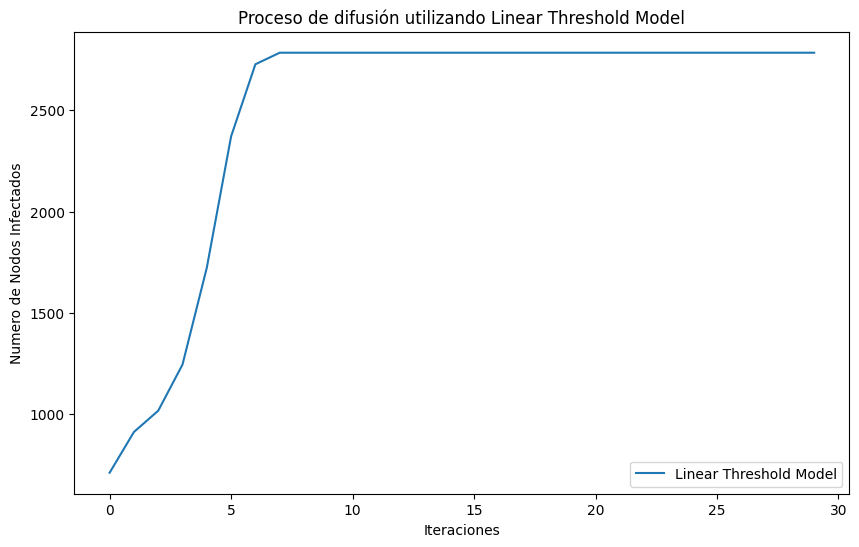

In [13]:
# Visualizacion de resultados
infected_lt = [iteration['node_count'][1] for iteration in iterations_lt]
plt.figure(figsize=(10, 6))
plt.plot(infected_lt, label='Linear Threshold Model')
plt.xlabel('Iteraciones')
plt.ylabel('Numero de Nodos Infectados')
plt.title('Proceso de difusión utilizando Linear Threshold Model')
plt.legend()
plt.show()

Al analizar el gráfico, se puede apreciar como la influencia acumulada activa rápidamente a unos 2700 nodos aproximadamente, alcanzando un punto de equilibrio después de aproximadamente 7 iteraciones. Esto indica que solo los nodos en subgrupos bien conectados pudieron ser activados por la presión de sus vecinos, mientras que el resto de la red no fue influenciado debido a la falta de conexiones suficientes o influencia acumulada. Esto refleja una propagación efectiva pero limitada a las partes mejor conectadas de la red.

### Aplicación de Independent Cascade Model

In [21]:
# Inicicialización del modelo
ic_model = ep.IndependentCascadesModel(G)

# Configuración del modelo
config = mc.Configuration()
config.add_model_parameter('fraction_infected', 0.1)
for edge in G.edges():
    config.add_edge_configuration("threshold", edge, 0.1)
ic_model.set_initial_status(config)

# Ejecución del modelo
iterations_ic = ic_model.iteration_bunch(30)

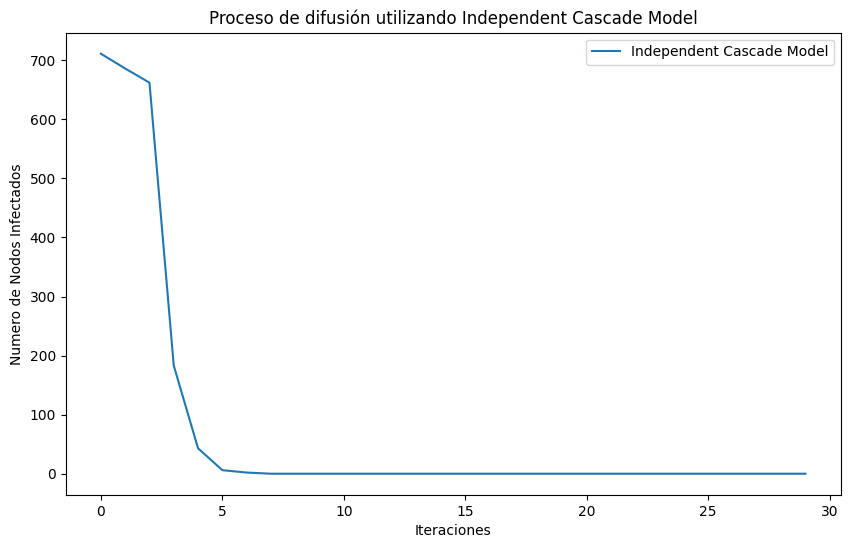

In [22]:
# Visualización de resultados
infected_ic = [iteration['node_count'][1] for iteration in iterations_ic]
plt.figure(figsize=(10, 6))
plt.plot(infected_ic, label='Independent Cascade Model')
plt.xlabel('Iteraciones')
plt.ylabel('Numero de Nodos Infectados')
plt.title('Proceso de difusión utilizando Independent Cascade Model')
plt.legend()
plt.show()

Al analizar el Independent Cascade Model, se puede ver un pico inicial con aproximadamente 700 nodos infectados que decrece rápidamente y se estabiliza en cero tras unas pocas iteraciones. Esto indica que la propagación de influencia es limitada y se detiene rápidamente, ya que la influencia individual de cada nodo no es suficiente para activar a otros de manera sostenida. Esto sugiere que la difusión basada en contagios individuales es menos efectiva en esta red, especialmente cuando las oportunidades de influencia directa son bajas.

### Dispersión de Influencia

Ahora se calcularan las dispersiones de influencia sobre los Top-10 Nodos obtenidos por cada medida de centralidad

In [23]:
top_10_in_degree = centralities.nlargest(10, 'In-Degree')['Node'].tolist()
top_10_out_degree = centralities.nlargest(10, 'Out-Degree')['Node'].tolist()
top_10_closeness = centralities.nlargest(10, 'Closeness')['Node'].tolist()
top_10_betweenness = centralities.nlargest(10, 'Betweenness')['Node'].tolist()
top_10_pagerank = centralities.nlargest(10, 'PageRank')['Node'].tolist()

In [30]:
# Funcion de Ejecucion del modelo
def run_lt_model(G, seeds):
    lt_model = ep.ThresholdModel(G)
    config = mc.Configuration()
    config.add_model_parameter('fraction_infected', 0.1)
    for node in G.nodes():
        config.add_node_configuration("threshold", node, 0.2)
        config.add_node_configuration("status", node, 0)
    for seed in seeds:
        config.add_node_configuration("status", seed, 1)
    lt_model.set_initial_status(config)
    iterations = lt_model.iteration_bunch(25)
    return iterations

In [31]:
# Funcion para calcular la influencia
def calculate_influence(iterations):
    return [iteration['node_count'][1] for iteration in iterations]

In [32]:
# Ejeciucion del modelo para los 10 nodos con mayor grado de entrada
iterations_in_degree = run_lt_model(G, top_10_in_degree)
iterations_out_degree = run_lt_model(G, top_10_out_degree)
iterations_closeness = run_lt_model(G, top_10_closeness)
iterations_betweenness = run_lt_model(G, top_10_betweenness)
iterations_pagerank = run_lt_model(G, top_10_pagerank)

In [33]:
# Calculo de la dispersion de la influencia
influence_in_degree = calculate_influence(iterations_in_degree)
influence_out_degree = calculate_influence(iterations_out_degree)
influence_closeness = calculate_influence(iterations_closeness)
influence_betweenness = calculate_influence(iterations_betweenness)
influence_pagerank = calculate_influence(iterations_pagerank)

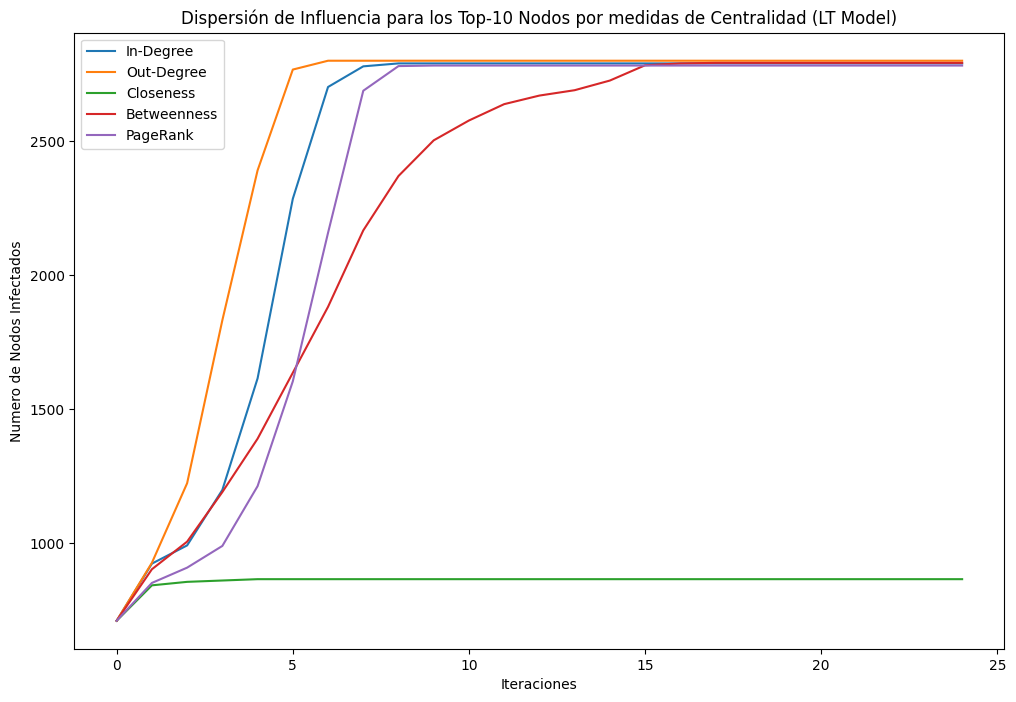

In [35]:
# Visualización
plt.figure(figsize=(12, 8))
plt.plot(influence_in_degree, label='In-Degree')
plt.plot(influence_out_degree, label='Out-Degree')
plt.plot(influence_closeness, label='Closeness')
plt.plot(influence_betweenness, label='Betweenness')
plt.plot(influence_pagerank, label='PageRank')
plt.xlabel('Iteraciones')
plt.ylabel('Numero de Nodos Infectados')
plt.title('Dispersión de Influencia para los Top-10 Nodos por medidas de Centralidad (LT Model)')
plt.legend()
plt.show()

En el gráfico generado, cada curva representa a una cantidad de nodos infectados (influenciados) a lo largo de ciertas iteraciones, según medidas de centralidad específicas.

Analizando el gráfico, se pueden ver las medidas de centralidad más eficientes para dispersar influencia.

* **In-Degree:** En el caso de la medida In-Degree, es efectiva para maximizar la propagación, puede ser debido a que los nodos con muchas conexiones entrantes tienen un grado de relevancia en la red, debido a que pueden estar conectados a otros nodos importantes. 
* **_Out-Degree:_** En el caso de la medida Out-Degree, este probó ser la más efectiva de las medidas de centralidad, esto es debido a que los nodos con más conexiones salientes tienen más posibilidades de influenciar o afectar un grán número de nodos.
* **Closeness:** Para la medida de Closeness, se puede notar que es significativamente diferente, donde no alcanza más de 500 nodos de influencia despues de 5 iteraciones, demostrando que no es una característica que facilite la dispersión de influencia.
* **Betweenness:** Para esta medida, se tiene el mismo impacto que In-Degree y Out-Degree, sin embargo, su curva es mucho más gradual. Esto puede significar que los intermediarios o "puentes" entre nodos tambien son utiles para propagar influencia.
* **PageRank:** Para esta medida, se tienen las mismas metricas que las anteriores, alcanza el mismo numero de propagación, dando a entender que los nodos que reciben mucha influencia de nodos importantes, tambien son efectivos para propagar influencia.

### Coeficiente de Correlación de Spearman

In [38]:
# Se vuelve a cargar las medidas de centralidad a un dataframe
centralidades = pd.read_csv("./Centralities_WikiVote.csv")

In [39]:
# Extraer los rankings de los nodos para cada medida de centralidad del DataFrame `centralities`
in_degree_ranks = centralidades['In-Degree'].rank(ascending=False)
out_degree_ranks = centralidades['Out-Degree'].rank(ascending=False)
closeness_ranks = centralidades['Closeness'].rank(ascending=False)
betweenness_ranks = centralidades['Betweenness'].rank(ascending=False)
pagerank_ranks = centralidades['PageRank'].rank(ascending=False)

In [42]:
# Correlaciones de Spearman por cada par de medidas
correlations = {
    "In-Degree vs Out-Degree": spearmanr(in_degree_ranks, out_degree_ranks),
    "In-Degree vs Closeness": spearmanr(in_degree_ranks, closeness_ranks),
    "In-Degree vs Betweenness": spearmanr(in_degree_ranks, betweenness_ranks),
    "In-Degree vs PageRank": spearmanr(in_degree_ranks, pagerank_ranks),
    "Out-Degree vs Closeness": spearmanr(out_degree_ranks, closeness_ranks),
    "Out-Degree vs Betweenness": spearmanr(out_degree_ranks, betweenness_ranks),
    "Out-Degree vs PageRank": spearmanr(out_degree_ranks, pagerank_ranks),
    "Closeness vs Betweenness": spearmanr(closeness_ranks, betweenness_ranks),
    "Closeness vs PageRank": spearmanr(closeness_ranks, pagerank_ranks),
    "Betweenness vs PageRank": spearmanr(betweenness_ranks, pagerank_ranks)
}

In [51]:
# Mostrar los resultados de las correlaciones con p-value < 0.05
significant_correlations = {key: value for key, value in correlations.items() if value.pvalue < 0.05}

# Mostrar los resultados de las correlaciones significativas
significant_correlations

{'In-Degree vs Closeness': SignificanceResult(statistic=np.float64(0.9939052268219611), pvalue=np.float64(0.0)),
 'In-Degree vs Betweenness': SignificanceResult(statistic=np.float64(0.7389992281422179), pvalue=np.float64(0.0)),
 'In-Degree vs PageRank': SignificanceResult(statistic=np.float64(0.9949652209484838), pvalue=np.float64(0.0)),
 'Out-Degree vs Betweenness': SignificanceResult(statistic=np.float64(0.4834289842254445), pvalue=np.float64(0.0)),
 'Closeness vs Betweenness': SignificanceResult(statistic=np.float64(0.7252526884390236), pvalue=np.float64(0.0)),
 'Closeness vs PageRank': SignificanceResult(statistic=np.float64(0.990039842092028), pvalue=np.float64(0.0)),
 'Betweenness vs PageRank': SignificanceResult(statistic=np.float64(0.7337501705326689), pvalue=np.float64(0.0))}

Estos P-Values cercanos a 0, nos indican que las correlaciones entre las medidas de centralidad son estadisticamente significativas.

In [45]:

# Crear un DataFrame para las correlaciones significativas
correlation_values = {
    'In-Degree vs Closeness': 0.9939,
    'In-Degree vs Betweenness': 0.7389,
    'In-Degree vs PageRank': 0.9949,
    'Out-Degree vs Betweenness': 0.4834,
    'Closeness vs Betweenness': 0.7252,
    'Closeness vs PageRank': 0.9900,
    'Betweenness vs PageRank': 0.7337
}

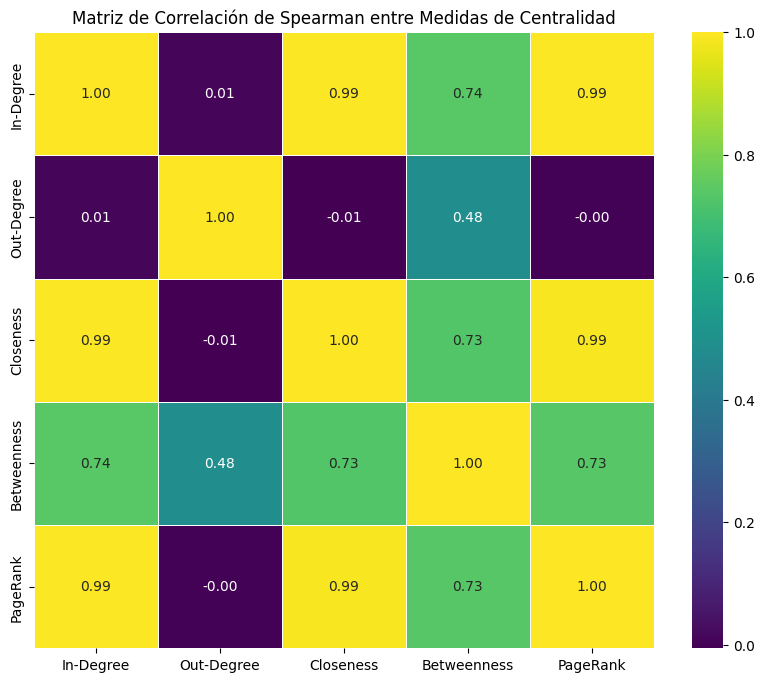

In [53]:
# Crear una matriz de correlación con las medidas de centralidad
correlation_matrix = centralities[['In-Degree', 'Out-Degree', 'Closeness', 'Betweenness', 'PageRank']].corr(method='spearman')

# Visualizar la matriz de correlación usando un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', linewidths=0.5, linecolor='white', fmt=".2f")
plt.title('Matriz de Correlación de Spearman entre Medidas de Centralidad')
plt.show()

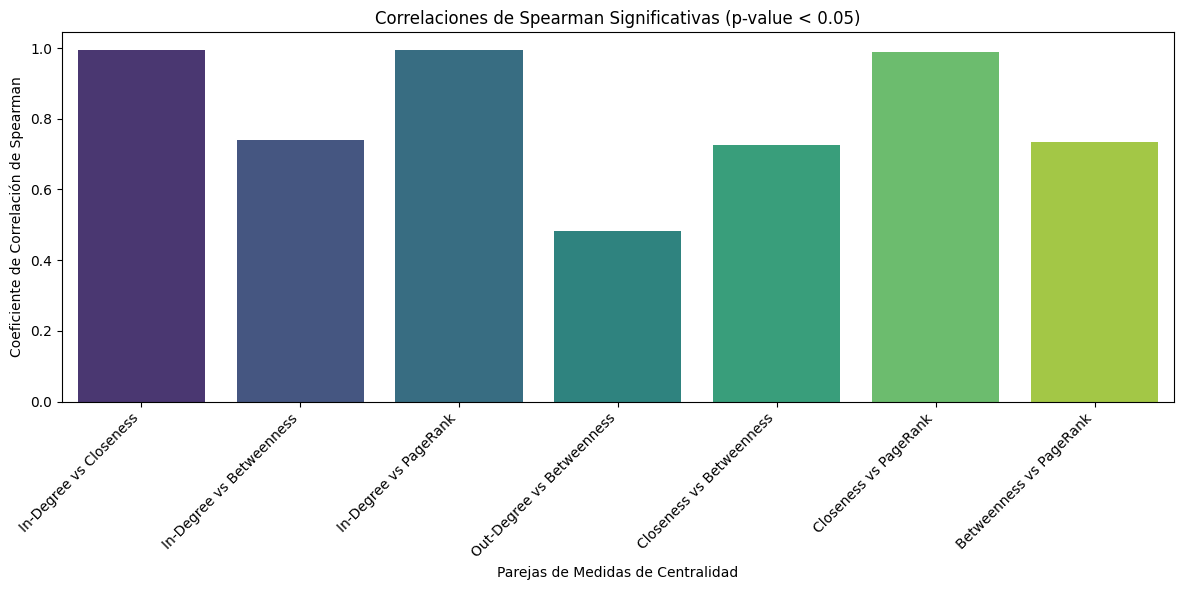

In [ ]:
# Otra forma de visualización
corr_df = pd.DataFrame(list(correlation_values.items()), columns=['Pair', 'Correlation'])

# Crear un gráfico de barras para visualizar las correlaciones significativas
plt.figure(figsize=(12, 6))
sns.barplot(x='Pair', y='Correlation', data=corr_df, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Correlaciones de Spearman Significativas (p-value < 0.05)')
plt.ylabel('Coeficiente de Correlación de Spearman')
plt.xlabel('Parejas de Medidas de Centralidad')
plt.tight_layout()
plt.show()

# Conclusiones

Los resultados de la dispersion de influencia, nos muestra que los Top-10 Nodos por medidas de centralidad, fueron los más efectivos para dispersar influencia.
En el caso de los nodos con alto **In-Degree** y **Out-Degree** revelan ser las características más efectivas para el objetivo de propagación de influencia, esto es debido a la cantidad de conexiones directas con otros nodos.
Para maximizar la propagación de influencia se recomiendan los nodos con alto **In-Degree** y **Out-Degree** como punto de partida, por su capacidad de alcanzar una amplia audiencia de manera rápida y efectiva.
Los nodos con altas métricas de **Betweenness** y **PageRank** juegan papeles relevantes para dispersar la influencia a diferentes partes de la red, a pesar de ser, en términos de propagación, menos influyentes que los nodos de alto grado.
Cabe destacar, que la medida de centralidad **Closeness** es el menos recomendado para el objetivo de dispersión de influencia en esta red, debido a su bajo rendimiento.